[Google Collab](https://www.githubtocolab.com/wilsonnguyen5163/INSE6220/blob/main/Project.ipynb)

In [2]:
import pycaret
import sklearn
import numpy as np
import math
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# sklearn offer a more customizable pca method, while pca.pca is simplier and offer built-in visualizer
from pca import pca


# **Load dataset**

In [3]:
data = pd.read_csv(r'ai4i2020.csv')
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# **Understanding the data**

**Dataset**:
- *TWF*, *HDF*, *PWF*, *OSF*, *RNF* are extensions of *Machine failure* aiming to provide more meaning for when a machine fails.
  - If any of the one-hot error feature value is 1, then *Machine failure* = 1 for that object
- *UDI*, *Product ID* are identifiers and hence are not useful for training purposes
- *Type* specifies the product quality variants. This feature derives from *Product ID*
  - There is an intrinsic hierarchy, as L = low quality, M = medium quality, H = high quality, so we assign increasing integer value for each.
  - Note that we are not considering this feature for PCA purposes, since it is not continuous but only a category of the object

In [4]:
X = data.drop(columns=["UDI", "Product ID", "Type", "TWF", "HDF", "PWF", "OSF", "RNF", "Machine failure"])
y = data['Machine failure']

In [5]:
X

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9
...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14
9996,298.9,308.4,1632,31.8,17
9997,299.0,308.6,1645,33.4,22
9998,299.0,308.7,1408,48.5,25


In [6]:
X.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


**Quick Insight**: Rotational speed and tool wear have large variance

In [7]:
y.value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

**Boxplot**

**Standardize** the dataset

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns

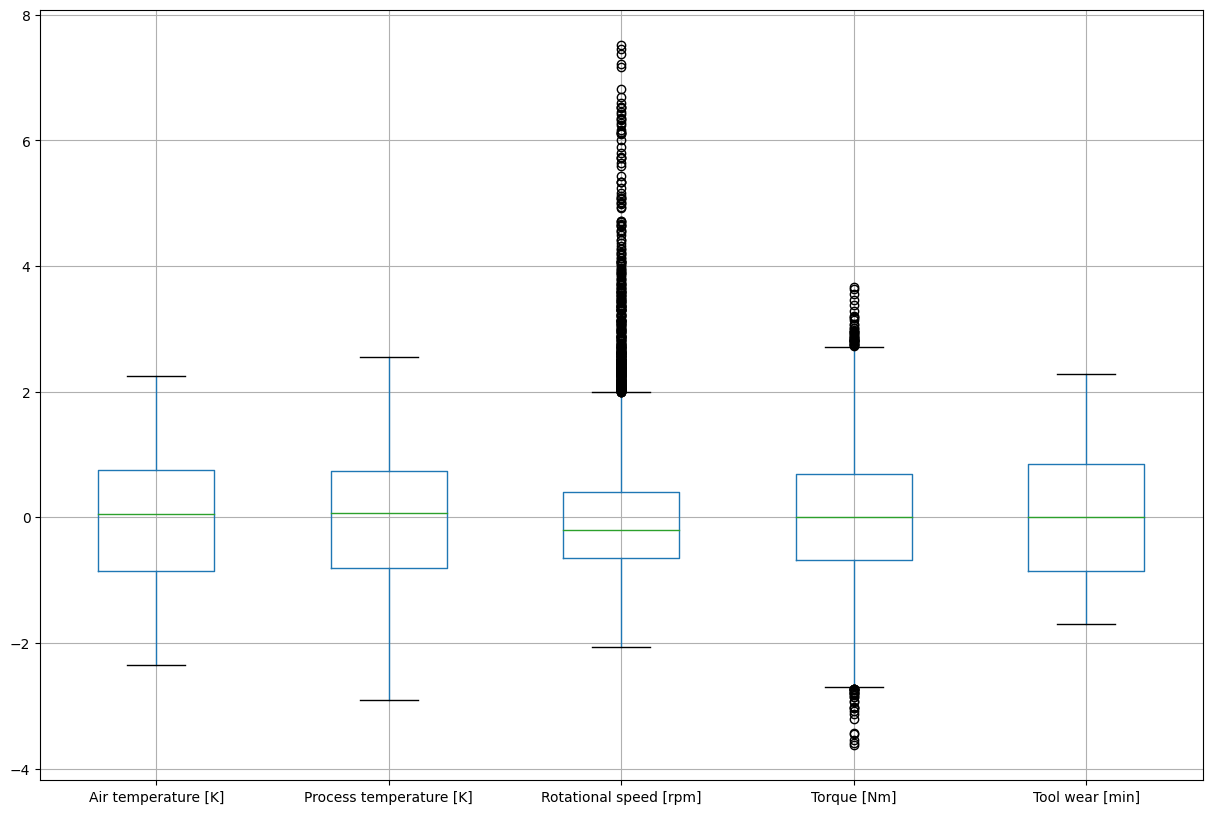

In [9]:
X_scaled.boxplot(figsize=(15,10))
plt.show()

**Insight**: 
- 4/5 features are normally distributed (ignore type)
  - Torque [Nm] seemingly show a normally distributed with quite a few outliers, equally on both ends of the tail
- Rotational speed [rpm] shows a more heavily positive-skewed (right skewed) with all outliers on the right-end of the tail. 

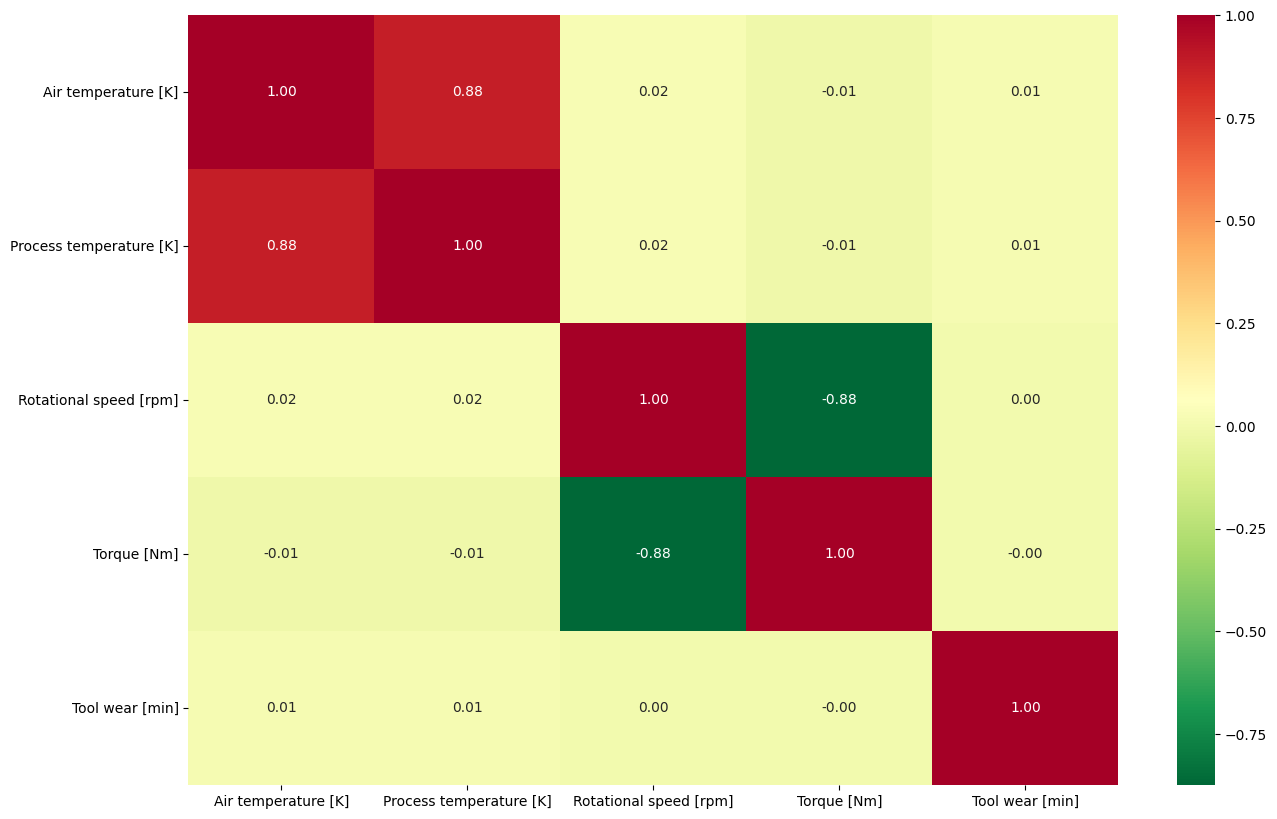

In [10]:
corr_matrix = X.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn_r', fmt='.2f')
plt.show()

**Insight**: 
- Process temprature [K] high positively correlated to Air temperature [K]  
- Rotational Speed [K] high negatively correlated to Torque [Nm]  

Heavily correlated features may be considered for removal for better generalization / visualization of the dataset

**Pair plot** confirms the correlations between the 2 pairs

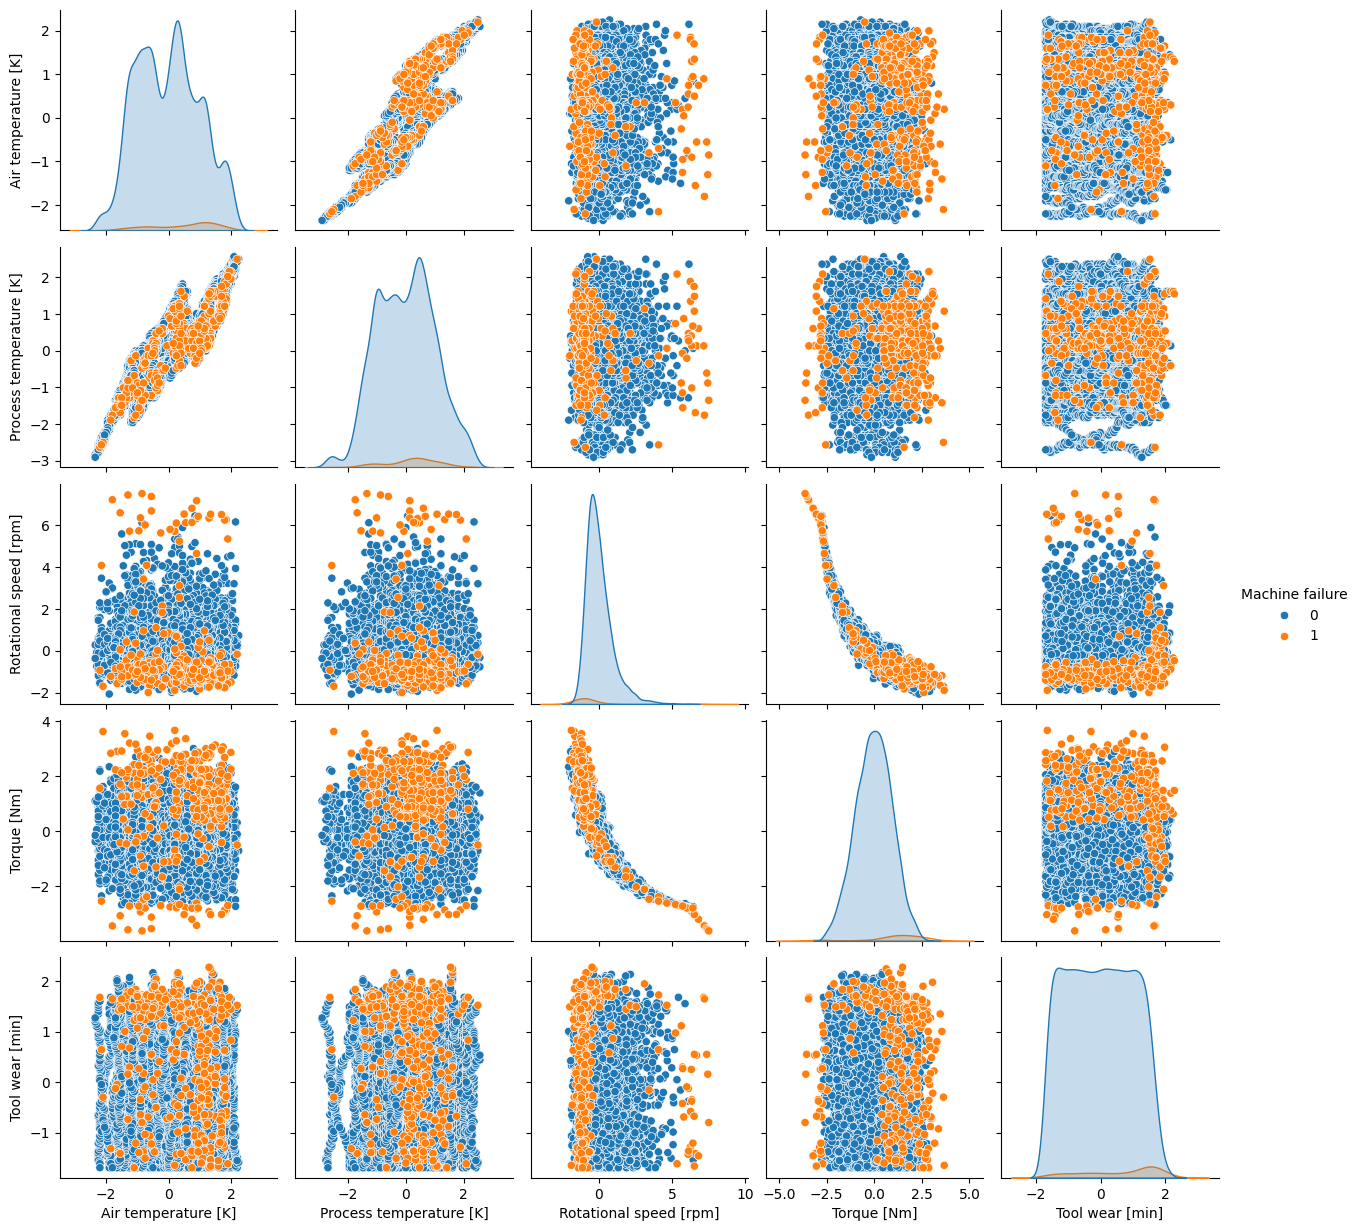

In [11]:
# Temporary sort the dataframe so that we can see the minority class (machines that failed) plot later, for visualization purposes
sns.pairplot(pd.concat([X_scaled, y], axis=1).sort_values(by="Machine failure", ascending=True), hue="Machine failure")
plt.show()

# **PCA**


In [12]:
pca_model = pca(n_components=0.90)
pca_transformed = pca_model.fit_transform(X_scaled)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [5] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


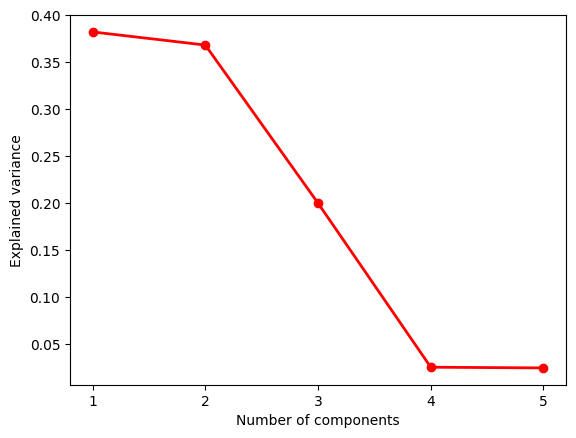

In [13]:
VR = pca_transformed['variance_ratio']
x = np.arange(len(VR)) + 1
plt.plot(x, VR, 'ro-', lw=2)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

Each feature 'explains' a fraction of the dataset's variance, so it is effectively the ratio of eigenvalue of a PC / total eigenvalue sum of all PCs

In [14]:
VR

array([0.3821481 , 0.36817048, 0.19991526, 0.02526552, 0.02450064])

**Cumulative Variance Plot**: 
- The bars represents individual principle component's contribution to explaining the variance of data
- The line on top represents the culmulative variance explained by the principle components

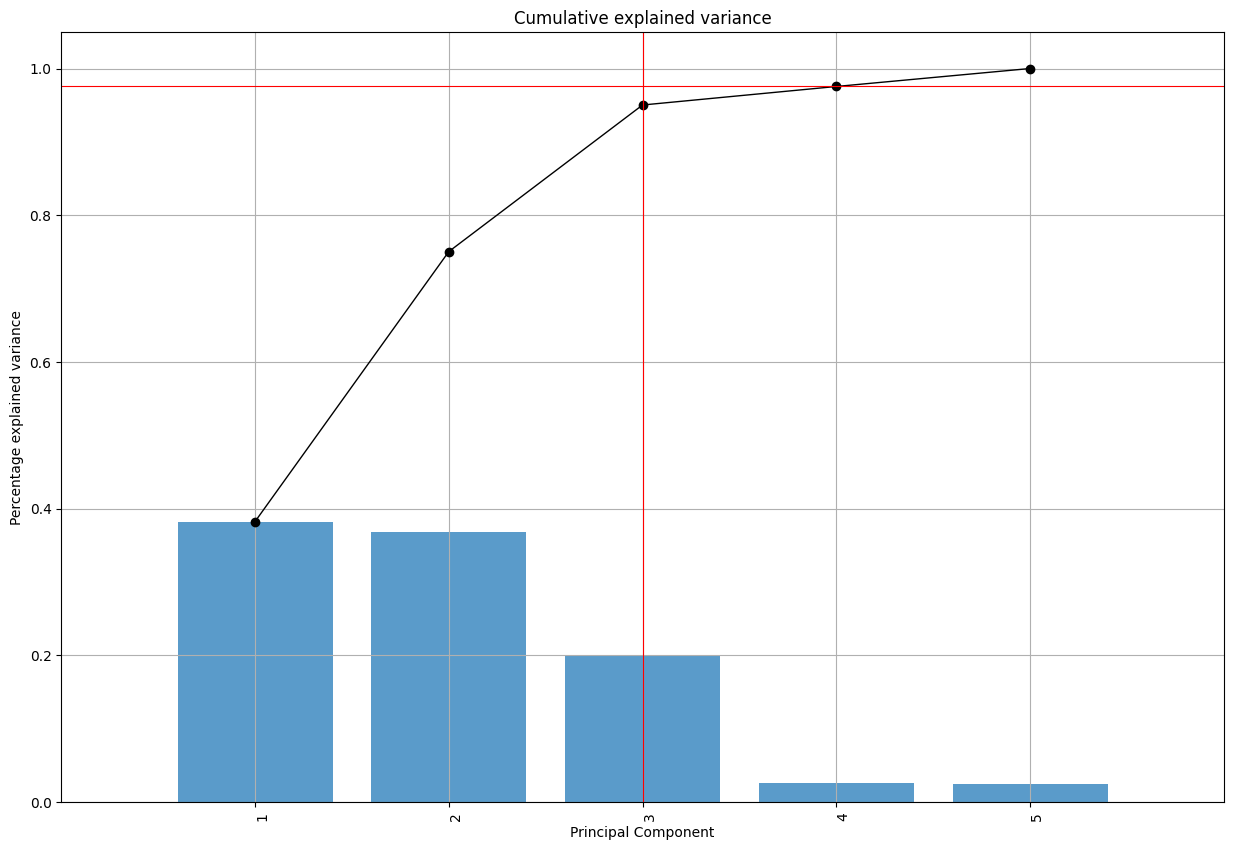

In [15]:
pca_model.plot(title="Cumulative explained variance")
plt.show()

**Insight**: we observe a clear elbow point at PC3, and we see that the first 3 principle components explain ~ 95% of the dataset's total variance
- Goal of PCA is to pick a reduced number of features (r < k) of the original k-features, that captures 'significant' number of variance of the dataset
  - This simplify classification results and improve model's performance.
- From this cumulative variance plot, we can agree on r = 3 is sufficient in capturing the majority (~ 95%) of the data's variance (can confirm below)

In [16]:
pca_transformed['explained_var']

array([0.3821481 , 0.75031858, 0.95023384, 0.97549936, 1.        ])

In [17]:
pca_model = pca(n_components=3)
X_pca_transformed = pca_model.fit_transform(X_scaled)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [18]:
X_pca_transformed['variance_ratio']

array([0.3821481 , 0.36817048, 0.19991526])

In [19]:
X_pca_transformed['explained_var']

array([0.3821481 , 0.75031858, 0.95023384])

In [20]:
pca_projected_X = X_pca_transformed['PC'].to_numpy()
features = X_pca_transformed['loadings'].columns

In [21]:
pca_projected_X

array([[-1.09384724,  0.85420978, -1.66641594],
       [-1.60267842,  0.215765  , -1.61886919],
       [-1.59940629,  0.40164128, -1.5862475 ],
       ...,
       [-0.13567522,  1.36957843, -1.32889308],
       [-1.5032338 , -0.09865482, -1.27955665],
       [-0.83704079,  0.5811135 , -1.20217442]])

In [22]:
X_pca_transformed['loadings']

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
PC1,0.505733,0.504865,0.496478,-0.492512,0.016963
PC2,-0.493938,-0.494847,0.503423,-0.507464,-0.014075
PC3,-0.015324,-0.015730,-0.003040,-0.000490,0.999754


In [23]:
X_pca_transformed['loadings'].T

,PC1,PC2,PC3
Air temperature [K],0.505733,-0.493938,-0.015324
Process temperature [K],0.504865,-0.494847,-0.015730
Rotational speed [rpm],0.496478,0.503423,-0.003040
Torque [Nm],-0.492512,-0.507464,-0.000490
Tool wear [min],0.016963,-0.014075,0.999754


Each row i of pca_loading == influence vector of ith feature

In [24]:
pca_loading = X_pca_transformed['loadings'].to_numpy().T
pca_loading

array([[ 5.05733117e-01, -4.93938038e-01, -1.53244151e-02],
       [ 5.04864639e-01, -4.94846528e-01, -1.57295452e-02],
       [ 4.96477652e-01,  5.03423000e-01, -3.03981958e-03],
       [-4.92511825e-01, -5.07463604e-01, -4.90137362e-04],
       [ 1.69633307e-02, -1.40748951e-02,  9.99754101e-01]])

In [25]:
top_influences= pca_model.compute_topfeat()
top_influences

,PC,feature,loading,type
0,PC1,Air temperature [K],0.505733,best
1,PC2,Torque [Nm],-0.507464,best
2,PC3,Tool wear [min],0.999754,best
3,PC1,Process temperature [K],0.504865,weak
4,PC2,Rotational speed [rpm],0.503423,weak


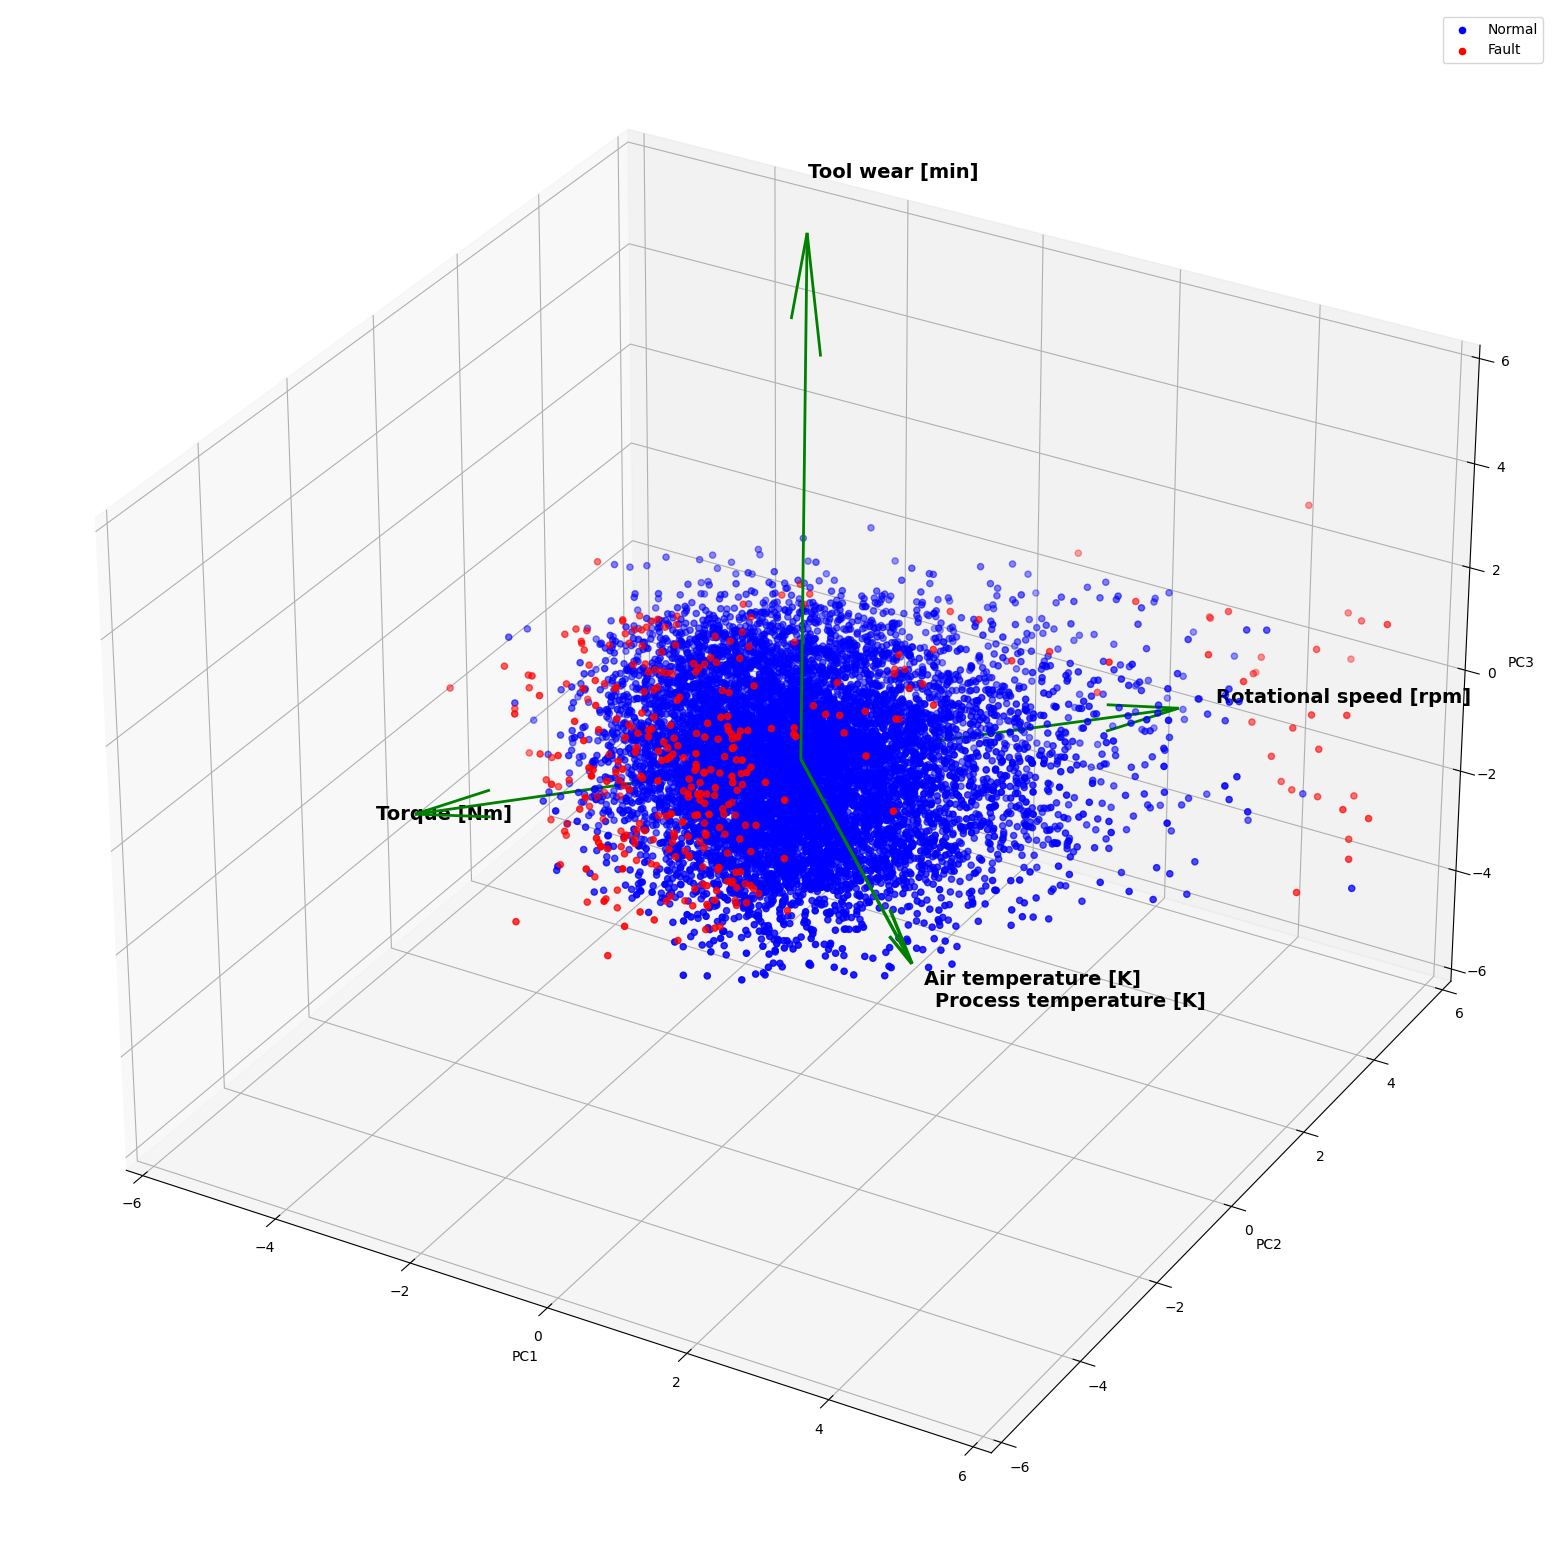

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(111, projection='3d')

scatter_normal = ax.scatter(pca_projected_X[y == 0, 0], pca_projected_X[y == 0, 1],
                      pca_projected_X[y == 0, 2], c='blue', label='Normal')

# Scatter plot for Label 1 (color them red)
scatter_fault = ax.scatter(pca_projected_X[y == 1, 0], pca_projected_X[y == 1, 1],
                      pca_projected_X[y == 1, 2], c='red', label='Fault')
ax.legend()

# Draw the influence vector of each feature along all PC's
for i in range(pca_loading.shape[0]):
    ax.quiver(0, 0, 0, pca_loading[i, 0], pca_loading[i, 1], pca_loading[i, 2],
              length=np.linalg.norm(pca_loading[i])*10, color='green', arrow_length_ratio=0.2, linewidth=2)
    if (i == 1):
        ax.text(pca_loading[i, 0]*np.linalg.norm(pca_loading[i])*12, pca_loading[i, 1]*np.linalg.norm(pca_loading[i])*12, pca_loading[i, 2]*np.linalg.norm(pca_loading[i])*12,
                f'{features[i]}', color='black', fontsize=14, fontweight='bold')
    else:
        ax.text(pca_loading[i, 0]*np.linalg.norm(pca_loading[i])*11, pca_loading[i, 1]*np.linalg.norm(pca_loading[i])*11, pca_loading[i, 2]*np.linalg.norm(pca_loading[i])*11,
                f'{features[i]}', color='black', fontsize=14, fontweight='bold')
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Zoom out the grid to see the vector better
ax.set_xlim([-6, 6])  # Adjust the x-axis limit
ax.set_ylim([-6, 6])  # Adjust the y-axis limit
ax.set_zlim([-6, 6])  # Adjust the z-axis limit


# Show the plot
plt.legend()
plt.show()

**Insight**: the individual feature vector helps visualize how each feature influences the score of Principle Components along the PC's respective axis (the correlation between the feature and PCs)
- Notice air temperature and process temperature influences roughly in the same direction, we can verify by looking at the loadings, that air temperature and process temperature columns are almost identical

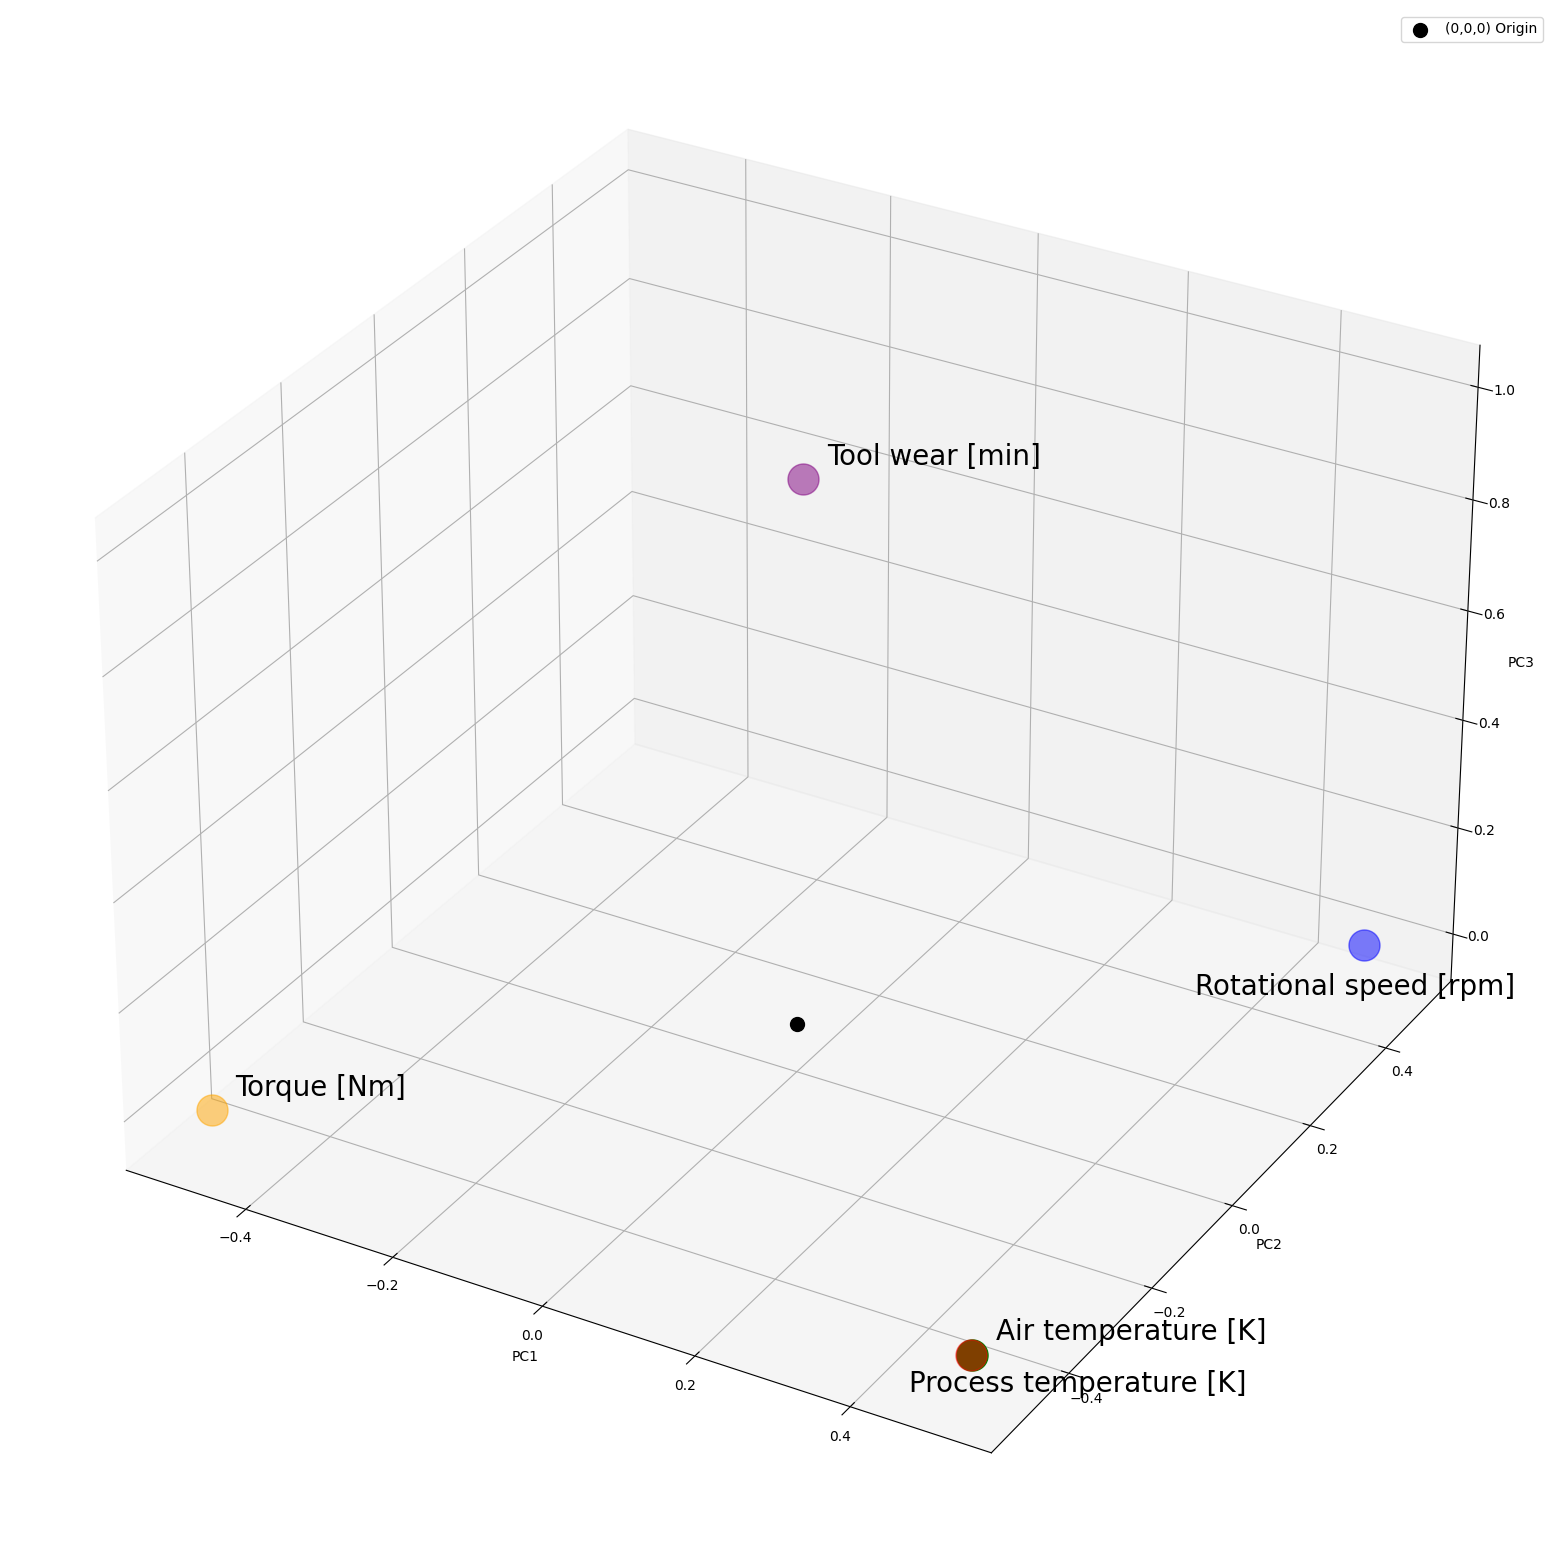

In [27]:
fig = plt.figure(figsize=(25, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0, 0, 0, s=100, color='black', label="(0,0,0) Origin")
ax.scatter( pca_loading[0, 0], pca_loading[0, 1], pca_loading[0, 2], s=500,
            color='green')
ax.text(pca_loading[0, 0]+0.02, pca_loading[0, 1]+0.02,
        pca_loading[0, 2]+0.02, "Air temperature [K]", fontsize=20)

ax.scatter(pca_loading[1, 0], pca_loading[1, 1], pca_loading[1, 2], s=500,
           color='red', alpha=0.5)
ax.text(pca_loading[1, 0]-0.05, pca_loading[1, 1]-0.05,
        pca_loading[1, 2]-0.05, "Process temperature [K]", fontsize=20)

ax.scatter(pca_loading[2, 0], pca_loading[2, 1], pca_loading[2, 2], s=500,
           color='blue', alpha=0.5)
ax.text(pca_loading[2, 0]-0.15, pca_loading[2, 1]-0.15,
        pca_loading[2, 2]-0.05, "Rotational speed [rpm]", fontsize=20)

ax.scatter(pca_loading[3, 0], pca_loading[3, 1], pca_loading[3, 2], s=500,
           color='orange', alpha=0.5)
ax.text(pca_loading[3, 0]+0.02, pca_loading[3, 1]+0.02,
        pca_loading[3, 2]+0.02, "Torque [Nm]", fontsize=20)

ax.scatter(pca_loading[4, 0], pca_loading[4, 1], pca_loading[4, 2], s=500,
           color='purple', alpha=0.5)
ax.text(pca_loading[4, 0]+0.02, pca_loading[4, 1]+0.02,
        pca_loading[4, 2]+0.02, "Tool wear [min]", fontsize=20)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
# Show the plot
plt.legend()
plt.show()

**Obtaining the 3 Principle Components**

In [28]:
X_pca_transformed['loadings']

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
PC1,0.505733,0.504865,0.496478,-0.492512,0.016963
PC2,-0.493938,-0.494847,0.503423,-0.507464,-0.014075
PC3,-0.015324,-0.015730,-0.003040,-0.000490,0.999754


Supposed a tuple is defined by X = {x1, x2, x3, x4, x5} corresponding to {Air temperature [K],	Process temperature [K],	Rotational speed [rpm],	Torque [Nm],	Tool wear [min] }
First principle component PC1: 0.505733x1 + 0.504865x2 + 0.496478x3 + 0.492512x4 + 0.016963x5  
    We can observe that for PC1, x5 contributes the least, so we will ignore this variable for PC1 computation

# Anomaly Detection


In [29]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import IsolationForest

X_scaled_normal = X_scaled[y == 0]
X_scaled_anomaly = X_scaled[y == 1]
y_normal = y[y == 0]
y_anomaly = y[y == 1]

In [30]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support

def output_formatter(predictions):
    predictions = np.where(predictions == 1, 0, 1)
    return predictions

# Isolation Forest

In [31]:
from itertools import product
from sklearn.metrics import f1_score, precision_score, recall_score

contanmination_factors = [0.2, 0.1, float(len(y_anomaly) / len(y_normal))]
num_itrees = [100, 150, 200]
max_samples = [0.1, 0.2, 'auto']
max_features = [0.5, 0.75]
k = 10
stratifier = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)
models=[]
for (contamination_factor, n_tree, max_sample, max_feature) in product(contanmination_factors, num_itrees, max_samples, max_features):
    IF_model = IsolationForest(contamination=contamination_factor, n_estimators=n_tree, max_features=max_feature, max_samples=max_sample, n_jobs=-1 , random_state=42)
    models.append(IF_model)

In [32]:
IF_scores = []
for model in models:
    rec, pre, f1 = 0,0,0
    for train_idx, test_idx in stratifier.split(X_scaled_train, y_train):
        X_train, X_test_anomaly = X_scaled_train.iloc[train_idx], X_scaled_train.iloc[test_idx]
        y_t, y_test_anomaly = y_train.iloc[train_idx], y_train.iloc[test_idx]
        model.fit(X_train[y_t==0])
        predictions = output_formatter(model.predict(X_test_anomaly))
        p = precision_score(y_test_anomaly, predictions)
        r = recall_score(y_test_anomaly, predictions)
        f = f1_score(y_test_anomaly, predictions)
        rec += r
        pre += p
        f1 += f
    IF_scores.append([rec/k, pre/k, f1/k])
IF_scores = np.array(IF_scores)

In [33]:
best_IFregular_i = np.argmax(IF_scores[:,2])
IF_nontuned_regular_model = models[best_IFregular_i]

Custom threshold tuning, basically wrapping prediction within a wrapper.  
What it does is using the current model's to compute an anomaly_score of an unknown point.   
The manual threshold is set so that if anomaly_score is less than some threshold, we mark it as anomaly.  
Continue moving the threshold around to maximize f1_score

In [177]:
best_f1 = 0
best_score = []
best_model = None
best_params = None

IF_nontuned_regular_model.fit(X_scaled_train[y == 0])
scores = np.array(IF_nontuned_regular_model.decision_function(X_scaled_test))

for thresh in np.linspace(-1, 1, 2000):
    preds = (scores < thresh).astype(int)  # 1 = anomaly
    p = precision_score(y_test, preds)
    r = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_score = [r, p, f1]
        best_model = IF_nontuned_regular_model
        best_params = IF_nontuned_regular_model.get_params()
        best_params['threshold'] = thresh
best_score

[0.18627450980392157, 0.2714285714285714, 0.22093023255813954]

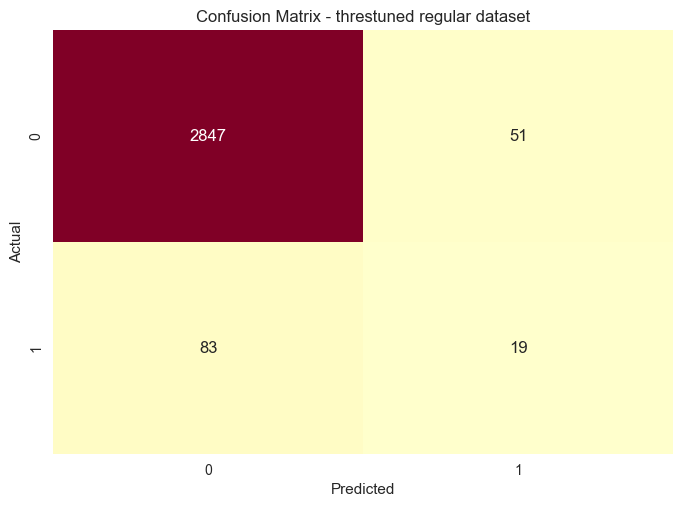

In [178]:
predictions_thresholdTuned = (IF_nontuned_regular_model.decision_function(X_scaled_test) < best_params['threshold']).astype(int)

sns.heatmap(confusion_matrix(y_test, predictions_thresholdTuned), annot=True, fmt="d", cmap= 'YlOrRd', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - threstuned regular dataset")
plt.show()

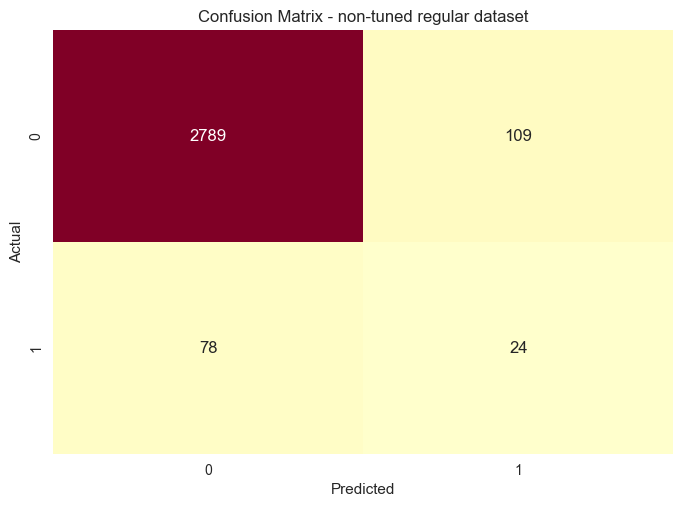

In [179]:
predictions_no_thresholdtune = output_formatter(
    IF_nontuned_regular_model.predict(X_scaled_test))
sns.heatmap(confusion_matrix(y_test, predictions_no_thresholdtune),
            annot=True, fmt="d", cmap='YlOrRd', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - non-tuned regular dataset")
plt.show()

In [180]:
print(recall_score(y_test, predictions_thresholdTuned),
      precision_score(y_test, predictions_thresholdTuned), f1_score(y_test, predictions_thresholdTuned))

0.18627450980392157 0.2714285714285714 0.22093023255813954


In [181]:
print(recall_score(y_test, predictions_no_thresholdtune),
      precision_score(y_test, predictions_no_thresholdtune), f1_score(y_test, predictions_no_thresholdtune))

0.23529411764705882 0.18045112781954886 0.20425531914893616


In [182]:
columns = ['Recall', 'Precision', "F-score"]
type = pd.DataFrame(["Regular, non-tuned", "Regular, threshold_tuned"], columns=['Test type: '])

res_regular = [[recall_score(y_test, predictions_no_thresholdtune),
                precision_score(y_test, predictions_no_thresholdtune), f1_score(y_test, predictions_no_thresholdtune)], [recall_score(y_test, predictions_thresholdTuned),
               precision_score(y_test, predictions_thresholdTuned), f1_score(y_test, predictions_thresholdTuned)]]
regular_dataset_score = pd.concat([type, pd.DataFrame(res_regular, columns=columns)], axis=1)
regular_dataset_score.set_index('Test type: ', inplace=True)
regular_dataset_score

,Recall,Precision,F-score
Test type:,,,
"Regular, non-tuned",0.235294,0.180451,0.204255
"Regular, threshold_tuned",0.186275,0.271429,0.220930


In [40]:
X_pca_train, X_pca_test, y_train, y_test_pca = train_test_split(X_pca_transformed['PC'], y, stratify=y, random_state=42, test_size=0.3)

In [41]:
# PCA transformed model
IF_pca_scores = []
for model in models:
    rec, pre, f1 = 0, 0, 0
    for train_idx, test_idx in stratifier.split(X_pca_train, y_train):
        X_train, X_test_anomaly = X_pca_train.iloc[train_idx], X_pca_train.iloc[test_idx]
        y_t, y_test_anomaly = y_train.iloc[train_idx], y_train.iloc[test_idx]
        model.fit(X_train[y_t == 0])
        predictions = output_formatter(model.predict(X_test_anomaly))
        p = precision_score(y_test_anomaly, predictions)
        r = recall_score(y_test_anomaly, predictions)
        f = f1_score(y_test_anomaly, predictions)
        rec += r
        pre += p
        f1 += f
    IF_pca_scores.append([rec/k, pre/k, f1/k])
IF_pca_scores = np.array(IF_pca_scores)

In [42]:
best_pca_transformed_i = np.argmax(IF_pca_scores[:, 2])
IF_nontuned_pca_model = models[best_pca_transformed_i]

In [185]:
best_f1 = 0
best_score = []
best_model = None
best_params = None

IF_nontuned_pca_model.fit(X_pca_train[y_train==0])
scores_pca = np.array(IF_nontuned_pca_model.decision_function(X_pca_test))

for thresh in np.linspace(-1, 1, 2000):
    preds = (scores_pca < thresh).astype(int)  # 1 = anomaly
    p = precision_score(y_test, preds)
    r = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_score = [r, p, f1]
        best_model = IF_nontuned_pca_model
        best_params = IF_nontuned_pca_model.get_params()
        best_params['threshold'] = thresh
best_score

[0.5294117647058824, 0.14794520547945206, 0.23126338329764454]

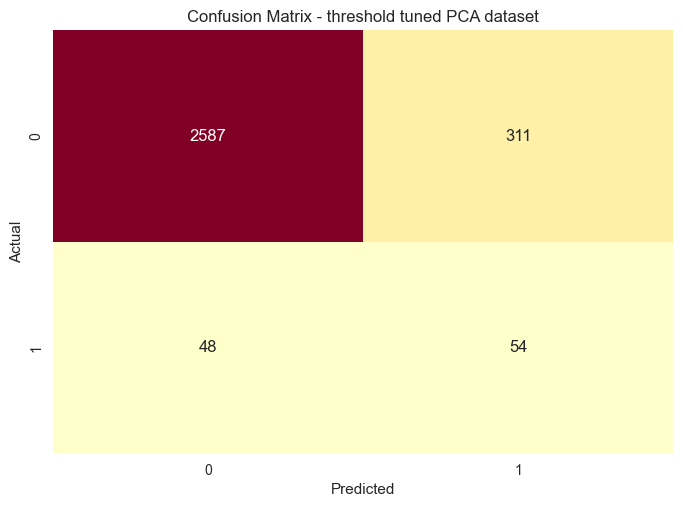

In [187]:
predictions_pca_thresholdTuned = (IF_nontuned_pca_model.decision_function(
    X_pca_test) < best_params['threshold']).astype(int)

sns.heatmap(confusion_matrix(y_test_pca, predictions_pca_thresholdTuned),
            annot=True, fmt="d", cmap='YlOrRd', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - threshold tuned PCA dataset")
plt.show()

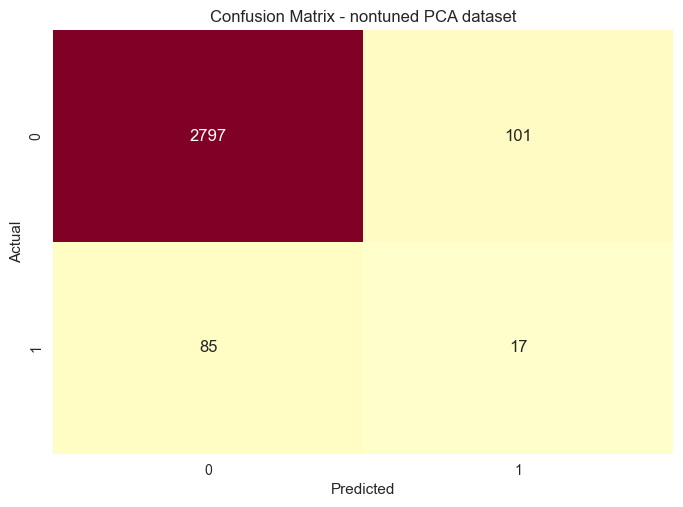

In [188]:
predictions_pca_not_thresholdTuned = output_formatter(
    IF_nontuned_pca_model.predict(X_pca_test))

sns.heatmap(confusion_matrix(y_test, predictions_pca_not_thresholdTuned),
            annot=True, fmt="d", cmap='YlOrRd', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - nontuned PCA dataset")
plt.show()

In [189]:
pca_type = pd.DataFrame(
    ["PCA, non-tuned", "PCA, threshold_tuned"], columns=['Test type: '])

res_PCA = [[recall_score(y_test, predictions_pca_not_thresholdTuned),
            precision_score(y_test, predictions_pca_not_thresholdTuned),
            f1_score(y_test, predictions_pca_not_thresholdTuned)],
           [recall_score(y_test, predictions_pca_thresholdTuned),
            precision_score(y_test, predictions_pca_thresholdTuned),
            f1_score(y_test, predictions_pca_thresholdTuned)]]
pca_dataset_score = pd.concat(
    [pca_type, pd.DataFrame(res_PCA, columns=columns)], axis=1)
pca_dataset_score.set_index('Test type: ', inplace=True)
pca_dataset_score

,Recall,Precision,F-score
Test type:,,,
"PCA, non-tuned",0.166667,0.144068,0.154545
"PCA, threshold_tuned",0.529412,0.147945,0.231263


In [190]:
compare_scores = pd.concat([regular_dataset_score, pca_dataset_score], axis=0)
compare_scores

,Recall,Precision,F-score
Test type:,,,
"Regular, non-tuned",0.235294,0.180451,0.204255
"Regular, threshold_tuned",0.186275,0.271429,0.220930
"PCA, non-tuned",0.166667,0.144068,0.154545
"PCA, threshold_tuned",0.529412,0.147945,0.231263


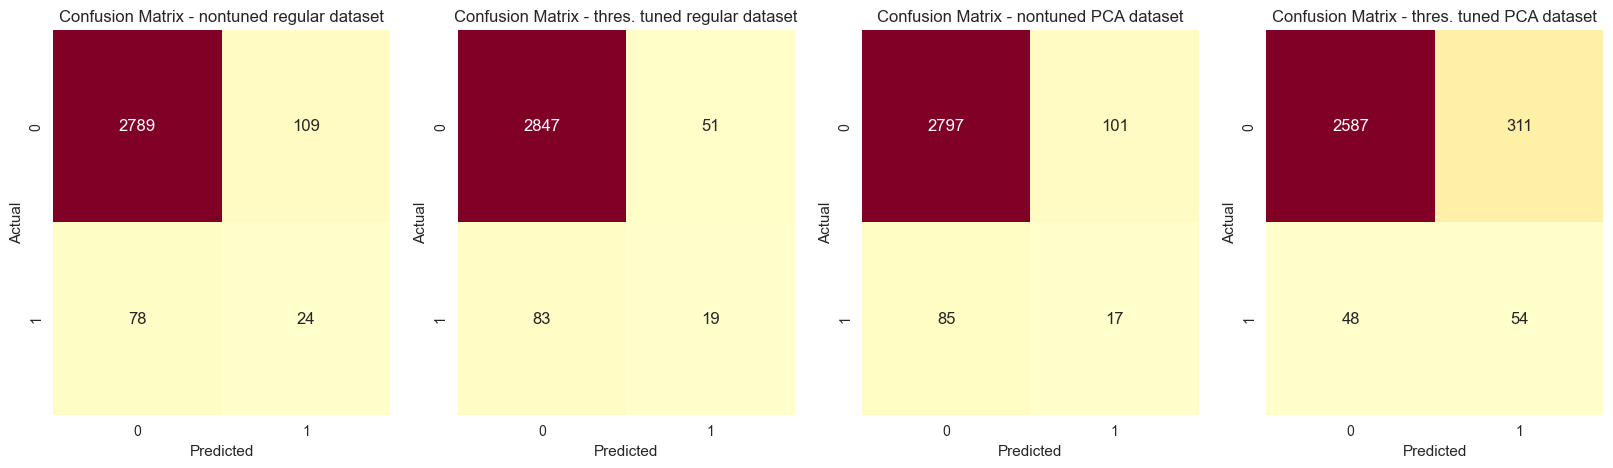

In [191]:
fig, axes = plt.subplots(1, 4, figsize=(20,5))

sns.heatmap(confusion_matrix(y_test, predictions_no_thresholdtune),
                         annot=True, fmt="d", cmap='YlOrRd', ax=axes[0], cbar=False)
axes[0].set_title("Confusion Matrix - nontuned regular dataset")
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

sns.heatmap(confusion_matrix(y_test, predictions_thresholdTuned),
            annot=True, fmt="d", cmap='YlOrRd', ax=axes[1], cbar=False)
axes[1].set_title("Confusion Matrix - thres. tuned regular dataset")
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

sns.heatmap(confusion_matrix(y_test, predictions_pca_not_thresholdTuned),
            annot=True, fmt="d", cmap='YlOrRd', ax=axes[2], cbar=False)
axes[2].set_title("Confusion Matrix - nontuned PCA dataset")
axes[2].set_ylabel('Actual')
axes[2].set_xlabel('Predicted')

sns.heatmap(confusion_matrix(y_test, predictions_pca_thresholdTuned),
            annot=True, fmt="d", cmap='YlOrRd', ax=axes[3], cbar=False)
axes[3].set_title("Confusion Matrix - thres. tuned PCA dataset")
axes[3].set_ylabel('Actual')
axes[3].set_xlabel('Predicted')

plt.show()

In [192]:
compare_scores

,Recall,Precision,F-score
Test type:,,,
"Regular, non-tuned",0.235294,0.180451,0.204255
"Regular, threshold_tuned",0.186275,0.271429,0.220930
"PCA, non-tuned",0.166667,0.144068,0.154545
"PCA, threshold_tuned",0.529412,0.147945,0.231263


# OC-SVM

In [50]:
from sklearn.svm import OneClassSVM
from itertools import product

gammas = ['scale', 'auto', 0.1, 0.001, 0.0001]
nus = [0.0001, 0.0005, 0.001, 0.01, 0.1]
kernels = ['linear', 'rbf', 'poly']
oc_svm_models = []
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)

for (nu, gamma, kernel) in product(nus, gammas, kernels):
    model = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)
    oc_svm_models.append(model)

Training on normal data exclusively

In [51]:
ocsvm_scores = []
for model in oc_svm_models:
    rec, pre, f1 = 0, 0, 0
    for train_idx, test_idx in stratifier.split(X_scaled_train, y_train):
        X_train, X_test_anomaly = X_scaled_train.iloc[train_idx], X_scaled_train.iloc[test_idx]
        y_t, y_test_anomaly = y_train.iloc[train_idx], y_train.iloc[test_idx]
        model.fit(X_train[y_t==0])
        predictions = output_formatter(model.predict(X_test_anomaly))
        p = precision_score(y_test_anomaly, predictions)
        r = recall_score(y_test_anomaly, predictions)
        f = f1_score(y_test_anomaly, predictions)
        rec += r
        pre += p
        f1 += f
    ocsvm_scores.append([rec/k, pre/k, f1/k])
ocsvm_scores = np.array(ocsvm_scores)

In [52]:
best_regular_i = np.argmax(ocsvm_scores[:, 2])
ocsvm_scores[best_regular_i]

array([0.37155797, 0.49621519, 0.41713635])

In [53]:
best_ocsvm_normal = oc_svm_models[best_regular_i]
scores = np.array([])
best_model = None
best_params = None

best_ocsvm_normal.fit(X_scaled_train[y_train==0])
scores = np.array(best_ocsvm_normal.decision_function(X_scaled_test))

best_f1 = f1_score(y_test, output_formatter(best_ocsvm_normal.predict(X_scaled_test)))
best_score = []

for thresh in np.linspace(scores.min(), scores.max(), 1000):
    preds = (scores < thresh).astype(int)  # 1 = anomaly
    p = precision_score(y_test, preds)
    r = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_score = [r, p, f1]
        best_model = best_ocsvm_normal
        best_params = best_ocsvm_normal.get_params()
        best_params['threshold'] = thresh
best_score

[0.37254901960784315, 0.4470588235294118, 0.40641711229946526]

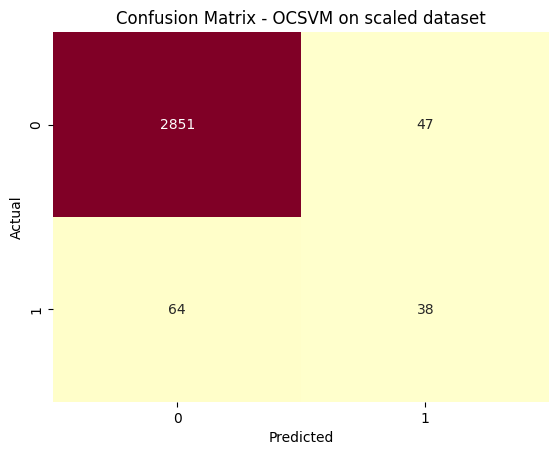

In [54]:
if best_params != None:
    preds = (best_ocsvm_normal.decision_function(X_scaled_test)<best_params['threshold']).astype(int)
else:
    preds = output_formatter(best_ocsvm_normal.predict(X_scaled_test))
sns.heatmap(confusion_matrix(y_test, preds),
            annot=True, fmt="d", cmap='YlOrRd', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - OCSVM on scaled dataset")
plt.show()

In [55]:
print("OCSVM on scaled dataset: ")
best_params

OCSVM on scaled dataset: 


{'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.01,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False,
 'threshold': 0.03658163743930887}

Train on PCA_transformed dataset

In [56]:
X_pca_train, X_pca_test, y_train_pca, y_test_pca = train_test_split(X_pca_transformed['PC'], y, stratify=y, random_state=42, test_size=0.3)

In [57]:
ocsvm_pca_scores = []
for model in oc_svm_models:
    rec, pre, f1 = 0, 0, 0
    for train_idx, test_idx in stratifier.split(X_pca_train, y_train_pca):
        X_train, X_test_anomaly = X_pca_train.iloc[train_idx], X_pca_train.iloc[test_idx]
        y_t, y_test_anomaly = y_train_pca.iloc[train_idx], y_train_pca.iloc[test_idx]
        model.fit(X_train[y_t==0])
        predictions = output_formatter(model.predict(X_test_anomaly))
        p = precision_score(y_test_anomaly, predictions)
        r = recall_score(y_test_anomaly, predictions)
        f = f1_score(y_test_anomaly, predictions)
        rec += r
        pre += p
        f1 += f
    ocsvm_pca_scores.append([rec/k, pre/k, f1/k])
ocsvm_pca_scores = np.array(ocsvm_pca_scores)

In [58]:
best_pca_i = np.argmax(ocsvm_pca_scores[:, 2])
ocsvm_pca_scores[best_pca_i]

array([0.31702899, 0.49152366, 0.3781761 ])

In [59]:
best_ocsvm_pca = oc_svm_models[best_pca_i]
scores = np.array([])

best_model = None
best_params = None

best_ocsvm_pca.fit(X_pca_train[y_train == 0])
scores = np.array(best_ocsvm_pca.decision_function(X_pca_test))
best_f1 = f1_score(y_test_pca, output_formatter(best_ocsvm_pca.predict(X_pca_test)))
best_score = []

for thresh in np.linspace(scores.min(), scores.max(), 1000):
    preds = (scores < thresh).astype(int)  # 1 = anomaly
    p = precision_score(y_test_pca, preds)
    r = recall_score(y_test_pca, preds)
    f1 = f1_score(y_test_pca, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_score = [r, p, f1]
        best_model = best_ocsvm_pca
        best_params = best_ocsvm_pca.get_params()
        best_params['threshold'] = thresh
best_score

[0.21568627450980393, 0.5365853658536586, 0.3076923076923077]

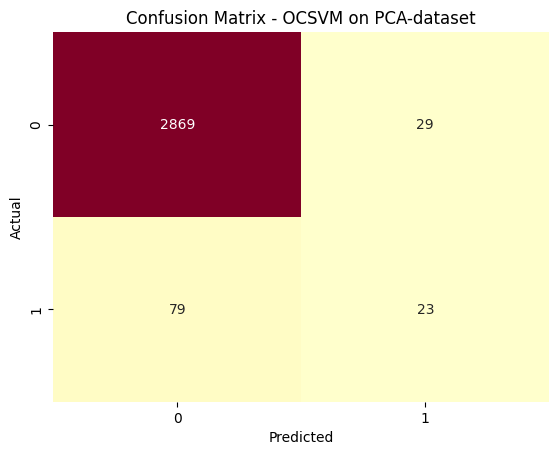

In [60]:
preds_pca = (best_ocsvm_pca.decision_function(X_pca_test)< 0).astype(int)
sns.heatmap(confusion_matrix(y_test_pca, preds_pca),
            annot=True, fmt="d", cmap='YlOrRd', cbar=False)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - OCSVM on PCA-dataset")
plt.show()

In [61]:
best_ocsvm_pca.fit(X_pca_train[y_train_pca==0])
pred_pca = output_formatter(best_ocsvm_pca.predict(X_pca_test))

best_ocsvm_normal.fit(X_scaled_train[y_train == 0])
pred_reg = output_formatter(best_ocsvm_normal.predict(X_scaled_test))

In [62]:
columns = ['Recall', 'Precision', "F-score"]
type = pd.DataFrame(['OCSVM - Standardized X', 
                    'OCSVM - PCA X'], columns=['Test type: '])
d = [[recall_score(y_test, pred_reg), precision_score(y_test, pred_reg), f1_score(y_test, pred_reg)],
     [recall_score(y_test_pca, pred_pca), precision_score(y_test_pca, pred_pca), f1_score(y_test_pca, pred_pca)]]
dataframe = pd.DataFrame(d, columns=columns)
dataframe = pd.concat([type, dataframe], axis=1)
dataframe.set_index('Test type: ')

,Recall,Precision,F-score
Test type:,,,
OCSVM - Standardized X,0.323529,0.440000,0.372881
OCSVM - PCA X,0.225490,0.442308,0.298701


# Classification Methods

In [63]:
from pycaret.classification import ClassificationExperiment

cls_exp = ClassificationExperiment()
cls_exp.setup(data.drop(columns=["UDI", "Product ID", "Type",
          "TWF", "HDF", "PWF", "OSF", "RNF"]), target="Machine failure", normalize=True)
best_base = cls_exp.compare_models()
best_base

[scatterd] >INFO> HTTP Request: GET https://api.gradio.app/gradio-messaging/en "HTTP/1.1 200 OK"


,Description,Value
0,Session id,787
1,Target,Machine failure
2,Target type,Binary
3,Original data shape,"(10000, 6)"
4,Transformed data shape,"(10000, 6)"
5,Transformed train set shape,"(7000, 6)"
6,Transformed test set shape,"(3000, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9827,0.9592,0.5909,0.8654,0.6975,0.6890,0.7048,0.0730
gbc,Gradient Boosting Classifier,0.9817,0.9659,0.5955,0.8233,0.6877,0.6786,0.6898,0.0750
catboost,CatBoost Classifier,0.9810,0.9754,0.5737,0.8117,0.6659,0.6566,0.6702,1.0020
lightgbm,Light Gradient Boosting Machine,0.9807,0.9747,0.5788,0.8054,0.6691,0.6595,0.6713,0.0510
xgboost,Extreme Gradient Boosting,0.9803,0.9695,0.5824,0.7915,0.6652,0.6554,0.6666,0.0700
dt,Decision Tree Classifier,0.9781,0.8259,0.6625,0.7012,0.6741,0.6629,0.6669,0.0090
et,Extra Trees Classifier,0.9781,0.9640,0.4223,0.8727,0.5635,0.5538,0.5952,0.0450
knn,K Neighbors Classifier,0.9739,0.8635,0.3431,0.7561,0.4641,0.4530,0.4939,0.2330
ada,Ada Boost Classifier,0.9716,0.9450,0.4098,0.6349,0.4916,0.4779,0.4932,0.0320
lr,Logistic Regression,0.9703,0.8856,0.1855,0.7056,0.2914,0.2823,0.3506,0.4550


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=787, verbose=0,
                       warm_start=False)

In [64]:
cls_pca_exp = ClassificationExperiment()
cls_pca_exp.setup(data.drop(columns=["UDI", "Product ID", "Type", "TWF", "HDF", "PWF", "OSF", "RNF"]), target="Machine failure", normalize=True, pca=True, pca_components=3)
best_X_pca = cls_pca_exp.compare_models()
best_X_pca

,Description,Value
0,Session id,2185
1,Target,Machine failure
2,Target type,Binary
3,Original data shape,"(10000, 6)"
4,Transformed data shape,"(10000, 4)"
5,Transformed train set shape,"(7000, 4)"
6,Transformed test set shape,"(3000, 4)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9710,0.9057,0.2620,0.7174,0.3723,0.3611,0.4133,0.0970
knn,K Neighbors Classifier,0.9700,0.8153,0.2453,0.6684,0.3526,0.3408,0.3889,0.0190
et,Extra Trees Classifier,0.9697,0.9161,0.1944,0.6820,0.2973,0.2872,0.3492,0.0430
catboost,CatBoost Classifier,0.9696,0.9454,0.2826,0.6329,0.3819,0.3688,0.4036,0.7510
gbc,Gradient Boosting Classifier,0.9686,0.9407,0.2536,0.6032,0.3502,0.3370,0.3733,0.0940
nb,Naive Bayes,0.9679,0.8757,0.0937,0.6883,0.1614,0.1549,0.2405,0.0100
ada,Ada Boost Classifier,0.9674,0.9299,0.2534,0.5613,0.3391,0.3252,0.3567,0.0420
xgboost,Extreme Gradient Boosting,0.9671,0.9321,0.2917,0.5811,0.3719,0.3570,0.3852,0.0310
lightgbm,Light Gradient Boosting Machine,0.9669,0.9392,0.2918,0.5550,0.3725,0.3572,0.3810,0.0530
lr,Logistic Regression,0.9661,0.7799,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=2185, verbose=0,
                       warm_start=False)

In [65]:
rf_base = cls_exp.create_model('rf')
gbc_base = cls_exp.create_model('gbc') 
rf_pca = cls_pca_exp.create_model('rf')
gbc_pca = cls_pca_exp.create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9886,0.9510,0.6522,1.0000,0.7895,0.7839,0.8028
1,0.9829,0.9611,0.5652,0.8667,0.6842,0.6758,0.6922
2,0.9857,0.9971,0.6087,0.9333,0.7368,0.7298,0.7475
3,0.9829,0.9650,0.6250,0.8333,0.7143,0.7056,0.7134
4,0.9857,0.9675,0.6250,0.9375,0.7500,0.7429,0.7592
5,0.9871,0.9714,0.6250,1.0000,0.7692,0.7630,0.7854
6,0.9757,0.9344,0.4583,0.7333,0.5641,0.5523,0.5685
7,0.9800,0.9272,0.5000,0.8571,0.6316,0.6220,0.6460
8,0.9786,0.9571,0.5000,0.8000,0.6154,0.6050,0.6227


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9857,0.9560,0.6957,0.8421,0.7619,0.7546,0.7583
1,0.9871,0.9837,0.6522,0.9375,0.7692,0.7628,0.7762
2,0.9829,0.9939,0.5652,0.8667,0.6842,0.6758,0.6922
3,0.9800,0.9821,0.5417,0.8125,0.6500,0.6401,0.6541
4,0.9843,0.9589,0.6667,0.8421,0.7442,0.7362,0.7415
5,0.9857,0.9863,0.6250,0.9375,0.7500,0.7429,0.7592
6,0.9729,0.9670,0.4583,0.6471,0.5366,0.5230,0.5313
7,0.9800,0.9107,0.5000,0.8571,0.6316,0.6220,0.6460
8,0.9814,0.9697,0.5833,0.8235,0.6829,0.6736,0.6843


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9671,0.9109,0.2609,0.5000,0.3429,0.3277,0.3461
1,0.9743,0.9524,0.2609,0.8571,0.4000,0.3907,0.4647
2,0.9700,0.9255,0.3478,0.5714,0.4324,0.4180,0.4316
3,0.9657,0.8940,0.0833,0.5000,0.1429,0.1344,0.1940
4,0.9771,0.9530,0.3750,0.9000,0.5294,0.5197,0.5728
5,0.9714,0.9152,0.2917,0.7000,0.4118,0.3997,0.4404
6,0.9700,0.8589,0.1250,1.0000,0.2222,0.2163,0.3482
7,0.9671,0.8936,0.2500,0.5455,0.3429,0.3284,0.3550
8,0.9786,0.8717,0.3750,1.0000,0.5455,0.5368,0.6057


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9629,0.9210,0.2609,0.4000,0.3158,0.2976,0.3048
1,0.9686,0.9521,0.2174,0.5556,0.3125,0.2996,0.3346
2,0.9771,0.9637,0.3913,0.8182,0.5294,0.5192,0.5566
3,0.9614,0.9436,0.0833,0.2857,0.1290,0.1153,0.1389
4,0.9729,0.9750,0.2917,0.7778,0.4242,0.4133,0.4663
5,0.9614,0.9440,0.1667,0.3636,0.2286,0.2116,0.2287
6,0.9729,0.9314,0.2083,1.0000,0.3448,0.3370,0.4502
7,0.9686,0.9295,0.2500,0.6000,0.3529,0.3396,0.3743
8,0.9729,0.9210,0.3750,0.6923,0.4865,0.4738,0.4975


In [66]:
rf_base_tuned = cls_exp.tune_model(rf_base, optimize='F1')
gbc_base_tuned = cls_exp.tune_model(gbc_base, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9871,0.9516,0.6957,0.8889,0.7805,0.7740,0.7801
1,0.9886,0.9889,0.6522,1.0000,0.7895,0.7839,0.8028
2,0.9871,0.9975,0.6957,0.8889,0.7805,0.7740,0.7801
3,0.9786,0.9850,0.5000,0.8000,0.6154,0.6050,0.6227
4,0.9857,0.9622,0.6667,0.8889,0.7619,0.7547,0.7630
5,0.9900,0.9948,0.7500,0.9474,0.8372,0.8321,0.8382
6,0.9771,0.9424,0.5417,0.7222,0.6190,0.6075,0.6142
7,0.9800,0.9574,0.5417,0.8125,0.6500,0.6401,0.6541
8,0.9729,0.9774,0.4167,0.6667,0.5128,0.4996,0.5143


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9886,0.9134,0.6522,1.0000,0.7895,0.7839,0.8028
1,0.9843,0.9500,0.5217,1.0000,0.6857,0.6785,0.7165
2,0.9829,0.8305,0.4783,1.0000,0.6471,0.6394,0.6855
3,0.9771,0.9068,0.3750,0.9000,0.5294,0.5197,0.5728
4,0.9800,0.9670,0.4583,0.9167,0.6111,0.6020,0.6404
5,0.9857,0.9836,0.6667,0.8889,0.7619,0.7547,0.7630
6,0.9714,0.8315,0.3750,0.6429,0.4737,0.4600,0.4778
7,0.9829,0.8105,0.5833,0.8750,0.7000,0.6915,0.7066
8,0.9814,0.9448,0.5000,0.9231,0.6486,0.6400,0.6719


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [67]:
cls_exp.evaluate_model(rf_base_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [68]:
cls_exp.evaluate_model(gbc_base_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [69]:
RF_predictions = cls_exp.predict_model(rf_base_tuned)
GBC_predictions = cls_exp.predict_model(gbc_base_tuned)

RF_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9843,0.9728,0.6569,0.8481,0.7403,0.7324,0.7388


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9827,0.9727,0.6275,0.8205,0.7111,0.7023,0.7091


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,prediction_label,prediction_score
7208,299.799988,309.700012,1707,29.100000,94,0,0,0.9949
5969,300.399994,310.799988,1491,35.900002,148,0,0,0.9995
7307,300.000000,310.399994,1385,52.099998,128,0,0,0.9987
6367,300.000000,309.600006,1571,33.099998,65,0,0,0.9993
2972,300.600006,309.399994,1432,44.200001,84,0,0,0.9993
...,...,...,...,...,...,...,...,...
9581,299.399994,310.600006,1418,53.099998,10,0,0,0.9994
3726,302.299988,311.200012,1505,36.700001,78,0,0,0.9995
3742,302.399994,311.399994,1564,35.000000,122,0,0,0.9995
5873,301.500000,311.100006,1396,43.500000,112,0,0,0.9995


In [135]:
RF_conf_matrix = confusion_matrix(RF_predictions['Machine failure'], RF_predictions['prediction_label'])
GBC_conf_matrix = confusion_matrix(GBC_predictions['Machine failure'], GBC_predictions['prediction_label'])

RF_scores = RF_predictions['prediction_score']
GBC_scores = GBC_predictions['prediction_score']
RF_scores

7208    0.9949
5969    0.9995
7307    0.9987
6367    0.9993
2972    0.9993
         ...  
9581    0.9994
3726    0.9995
3742    0.9995
5873    0.9995
6406    0.9993
Name: prediction_score, Length: 3000, dtype: float64

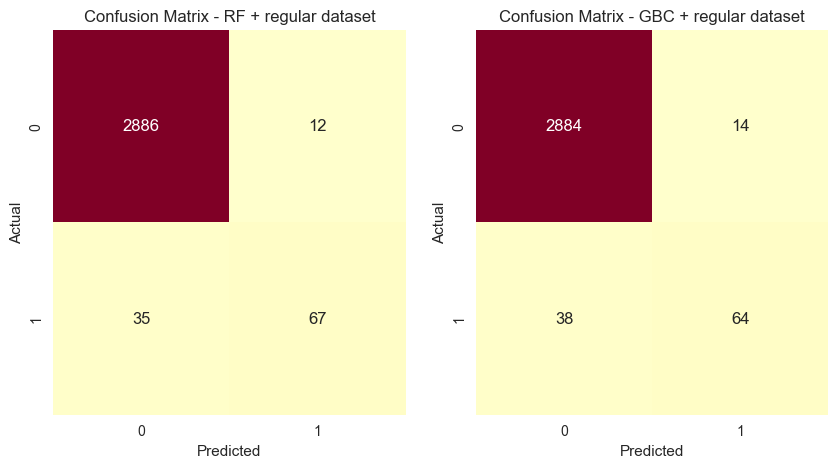

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.heatmap(RF_conf_matrix, ax=ax[0], fmt="d", annot=True, cmap='YlOrRd', cbar=False)
ax[0].set_title("Confusion Matrix - RF + regular dataset")
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

sns.heatmap(GBC_conf_matrix, ax=ax[1], fmt="d",
            annot=True, cmap='YlOrRd', cbar=False)
ax[1].set_title("Confusion Matrix - GBC + regular dataset")
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.show()

In [195]:
from imblearn.over_sampling import SMOTE
oversampling = SMOTE()

# Separate a test set for testing the training of SMOTE dataset
X_smote_, X_test_for_smote, y_smote_ , y_test_for_smote = train_test_split(X_scaled, y, test_size=3000, stratify=y, random_state=42)

# SMOTE over dataset, excluding the test set
X_smote, y_smote = oversampling.fit_resample(X_smote_, y_smote_)
X_smote, _, y_smote, _ = train_test_split(X_smote, y_smote, stratify=y_smote, train_size=10000, random_state=42)
dataset_smote = pd.concat((X_smote, y_smote), axis=1)
dataset_smote

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
11834,1.297432,0.302113,-1.009835,2.700592,-0.391238,1
12855,1.682057,1.256185,-1.313953,2.340388,-0.851017,1
4084,0.897464,0.670261,0.374976,-0.670808,-1.633141,0
1178,0.697480,0.468059,-0.383634,0.653371,-0.109205,0
7276,0.548891,0.240874,-1.101486,1.719604,1.460544,1
...,...,...,...,...,...,...
8214,-0.934742,-1.435233,-1.258244,2.743374,-0.666373,1
6626,-1.402354,-0.947360,2.109740,-1.593722,-0.847607,0
2631,-1.102378,-0.812558,-0.656957,0.964353,-0.109205,0
6950,-0.802401,-0.475554,0.017983,-0.460143,1.571838,0


In [196]:
from collections import Counter

counter = Counter(y_test_for_smote)
counter

Counter({0: 2898, 1: 102})

In [197]:
Counter(y_smote)

Counter({1: 5000, 0: 5000})

In [198]:
cls_exp_smote = ClassificationExperiment()
cls_exp_smote.setup(dataset_smote, target="Machine failure", normalize=True)
cls_exp_smote.compare_models()

,Description,Value
0,Session id,8763
1,Target,Machine failure
2,Target type,Binary
3,Original data shape,"(10000, 6)"
4,Transformed data shape,"(10000, 6)"
5,Transformed train set shape,"(7000, 6)"
6,Transformed test set shape,"(3000, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9810,0.9988,0.9891,0.9733,0.9812,0.9620,0.9622,0.0650
lightgbm,Light Gradient Boosting Machine,0.9799,0.9976,0.9889,0.9714,0.9800,0.9597,0.9599,0.0550
xgboost,Extreme Gradient Boosting,0.9784,0.9975,0.9871,0.9703,0.9786,0.9569,0.9571,0.0730
rf,Random Forest Classifier,0.9744,0.9976,0.9857,0.9641,0.9747,0.9489,0.9492,0.1000
catboost,CatBoost Classifier,0.9736,0.9962,0.9863,0.9620,0.9739,0.9471,0.9476,0.9390
dt,Decision Tree Classifier,0.9626,0.9626,0.9651,0.9603,0.9627,0.9251,0.9252,0.0130
knn,K Neighbors Classifier,0.9566,0.9836,0.9937,0.9251,0.9582,0.9131,0.9157,0.2510
gbc,Gradient Boosting Classifier,0.9553,0.9890,0.9751,0.9380,0.9562,0.9106,0.9114,0.1170
ada,Ada Boost Classifier,0.9274,0.9760,0.9354,0.9209,0.9280,0.8549,0.8551,0.0430
qda,Quadratic Discriminant Analysis,0.8389,0.9281,0.7837,0.8809,0.8292,0.6777,0.6822,0.0080


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=8763, verbose=0,
                     warm_start=False)

In [199]:
RF_smote = cls_exp_smote.create_model('rf')
GBC_smote = cls_exp_smote.create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9714,0.9972,0.9714,0.9714,0.9714,0.9429,0.9429
1,0.9800,0.9977,0.9914,0.9693,0.9802,0.9600,0.9603
2,0.9843,0.9982,0.9857,0.9829,0.9843,0.9686,0.9686
3,0.9686,0.9973,0.9829,0.9556,0.9690,0.9371,0.9375
4,0.9800,0.9981,0.9829,0.9773,0.9801,0.9600,0.9600
5,0.9671,0.9953,0.9886,0.9479,0.9678,0.9343,0.9351
6,0.9729,0.9970,0.9857,0.9610,0.9732,0.9457,0.9460
7,0.9814,0.9996,0.9971,0.9668,0.9817,0.9629,0.9633
8,0.9714,0.9976,0.9886,0.9558,0.9719,0.9429,0.9434


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9471,0.9862,0.9514,0.9433,0.9474,0.8943,0.8943
1,0.9586,0.9884,0.9857,0.9350,0.9597,0.9171,0.9185
2,0.9629,0.9890,0.9686,0.9576,0.9631,0.9257,0.9258
3,0.9543,0.9894,0.9743,0.9368,0.9552,0.9086,0.9093
4,0.9543,0.9880,0.9686,0.9417,0.9549,0.9086,0.9089
5,0.9471,0.9862,0.9829,0.9173,0.9490,0.8943,0.8966
6,0.9600,0.9859,0.9800,0.9423,0.9608,0.9200,0.9207
7,0.9600,0.9959,0.9829,0.9399,0.9609,0.9200,0.9210
8,0.9586,0.9916,0.9857,0.9350,0.9597,0.9171,0.9185


In [200]:
RF_predictions_smote = cls_exp_smote.predict_model(cls_exp_smote.tune_model(RF_smote, optimize='F1'), X_test_for_smote, raw_score=True)
GBC_predictions_smote = cls_exp_smote.predict_model(cls_exp_smote.tune_model(GBC_smote, optimize='F1'), X_test_for_smote, raw_score=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9657,0.9954,0.9629,0.9684,0.9656,0.9314,0.9314
1,0.9757,0.9959,0.9886,0.9638,0.9760,0.9514,0.9517
2,0.9714,0.9968,0.9743,0.9688,0.9715,0.9429,0.9429
3,0.9629,0.9956,0.9771,0.9500,0.9634,0.9257,0.9261
4,0.9629,0.9960,0.9657,0.9602,0.9630,0.9257,0.9257
5,0.9586,0.9946,0.9857,0.9350,0.9597,0.9171,0.9185
6,0.9671,0.9950,0.9829,0.9529,0.9677,0.9343,0.9347
7,0.9800,0.9992,0.9943,0.9667,0.9803,0.9600,0.9604
8,0.9714,0.9966,0.9886,0.9558,0.9719,0.9429,0.9434


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9729,0.9963,0.9686,0.9769,0.9727,0.9457,0.9457
1,0.9829,0.9983,0.9886,0.9774,0.9830,0.9657,0.9658
2,0.9843,0.9980,0.9829,0.9857,0.9843,0.9686,0.9686
3,0.9729,0.9977,0.9914,0.9559,0.9734,0.9457,0.9464
4,0.9800,0.9986,0.9829,0.9773,0.9801,0.9600,0.9600
5,0.9743,0.9963,0.9829,0.9663,0.9745,0.9486,0.9487
6,0.9800,0.9981,0.9886,0.9719,0.9802,0.9600,0.9601
7,0.9900,0.9997,1.0000,0.9804,0.9901,0.9800,0.9802
8,0.9771,0.9978,0.9886,0.9665,0.9774,0.9543,0.9545


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [201]:
RF_smote_conf_matrix = confusion_matrix(
    y_test_for_smote, RF_predictions_smote['prediction_label'])
GBC_smote_conf_matrix = confusion_matrix(
    y_test_for_smote, GBC_predictions_smote['prediction_label'])

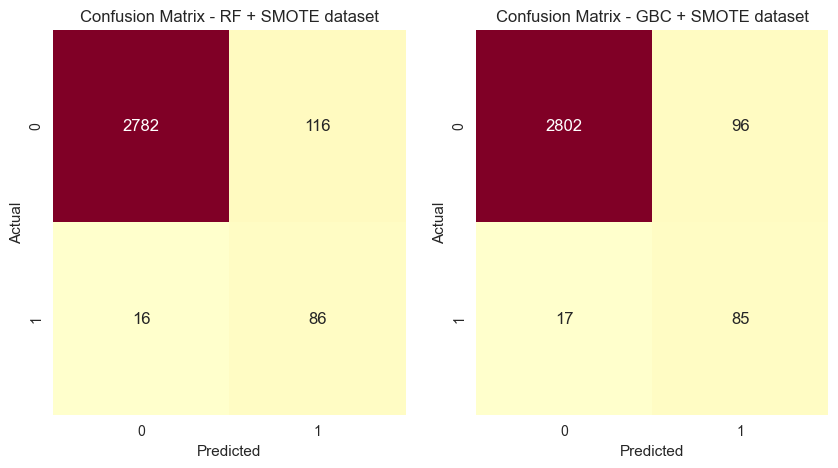

In [202]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.heatmap(RF_smote_conf_matrix, ax=ax[0], fmt="d",
            annot=True, cmap='YlOrRd', cbar=False)
ax[0].set_title("Confusion Matrix - RF + SMOTE dataset")
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

sns.heatmap(GBC_smote_conf_matrix, ax=ax[1], fmt="d",
            annot=True, cmap='YlOrRd', cbar=False)
ax[1].set_title("Confusion Matrix - GBC + SMOTE dataset")
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.show()

In [203]:
RF_predictions_smote

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],prediction_label,prediction_score_0,prediction_score_1
7809,-0.002465,0.939865,-0.009907,-0.460143,0.189298,0,1.00,0.00
9069,-1.402354,-1.216963,0.776594,-1.192455,0.393537,0,1.00,0.00
3170,0.197519,-0.205950,0.815640,-0.771125,0.927700,0,0.93,0.07
2750,-0.152453,-0.542955,-0.461727,0.061503,1.163360,0,0.99,0.01
6986,0.347507,0.737662,0.832374,-0.931632,0.833436,0,0.99,0.01
...,...,...,...,...,...,...,...,...
5270,1.747396,1.950878,-1.471348,2.449039,0.079323,1,0.32,0.68
4610,1.547412,0.805063,-0.807564,0.532991,0.566354,0,0.60,0.40
6434,0.147523,-0.071148,-0.249762,-0.149162,-1.177531,0,1.00,0.00
8351,-0.652413,-0.273351,0.821218,-1.383057,1.273335,0,0.92,0.08


In [204]:
roc_auc_RF_smote = roc_auc_score(
    y_test_for_smote, RF_predictions_smote['prediction_score_1'])
roc_auc_GBC_smote = roc_auc_score(
    y_test_for_smote, GBC_predictions_smote['prediction_score_1'])
columns = ['types', 'ROC_AUC', 'Recall', 'Precision', 'F1']

present_dataframe = pd.DataFrame([['RF_SMOTE', roc_auc_RF_smote, recall_score(y_test_for_smote, RF_predictions_smote['prediction_label']), precision_score(y_test_for_smote, RF_predictions_smote['prediction_label']), f1_score(y_test_for_smote, RF_predictions_smote['prediction_label'])],
                                  ['GBC_SMOTE', roc_auc_GBC_smote, recall_score(y_test_for_smote, GBC_predictions_smote['prediction_label']), precision_score(y_test_for_smote, GBC_predictions_smote['prediction_label']), f1_score(y_test_for_smote, GBC_predictions_smote['prediction_label'])]], columns=columns)

present_dataframe

,types,ROC_AUC,Recall,Precision,F1
0,RF_SMOTE,0.978692,0.843137,0.425743,0.565789
1,GBC_SMOTE,0.980066,0.833333,0.469613,0.600707


# ROC - Curve

In [205]:
from sklearn.metrics import roc_curve

In [206]:
IF_nontuned_regular_model.fit(X_scaled_train[y_train==0])
IF_prediction_scores = -IF_nontuned_regular_model.decision_function(X_scaled_test)
IF_nontuned_pca_model.fit(X_pca_train[y_train==0])
IF_prediction_pca_scores = -IF_nontuned_pca_model.decision_function(X_pca_test)

OCSVM_prediction_scores = -best_ocsvm_normal.decision_function(X_scaled_test)
OCSVM_prediction_pca_scores = -best_ocsvm_pca.decision_function(X_pca_test)

In [208]:
fpr_IF_reg, tpr_IF_reg, _ = roc_curve(y_test, IF_prediction_scores)
roc_auc_IF_reg = roc_auc_score(y_test, IF_prediction_scores)

fpr_IF_pca, tpr_IF_pca, _ = roc_curve(y_test_pca, IF_prediction_pca_scores)
roc_auc_IF_pca = roc_auc_score(y_test_pca, IF_prediction_pca_scores)

fpr_ocsvm_reg, tpr_ocsvm_reg, _ = roc_curve(y_test, OCSVM_prediction_scores)
roc_auc_OCSVM_reg = roc_auc_score(y_test, OCSVM_prediction_scores)

fpr_ocsvm_pca, tpr_ocsvm_pca, _ = roc_curve(y_test_pca, OCSVM_prediction_pca_scores)
roc_auc_OCSVM_pca = roc_auc_score(y_test_pca, OCSVM_prediction_pca_scores)

fpr_RF, tpr_RF, _ = roc_curve(RF_predictions['Machine failure'], -RF_scores)
roc_auc_RF = roc_auc_score(RF_predictions['Machine failure'], -RF_scores)

fpr_GBC, tpr_GBC, _ = roc_curve(GBC_predictions['Machine failure'], -GBC_scores)
roc_auc_GBC = roc_auc_score(GBC_predictions['Machine failure'], -GBC_scores)

fpr_RF_smote, tpr_RF_smote, _ = roc_curve(y_test_for_smote, RF_predictions_smote['prediction_score_1'])
fpr_GBC_smote, tpr_GBC_smote, _ = roc_curve(y_test_for_smote, GBC_predictions_smote['prediction_score_1'])

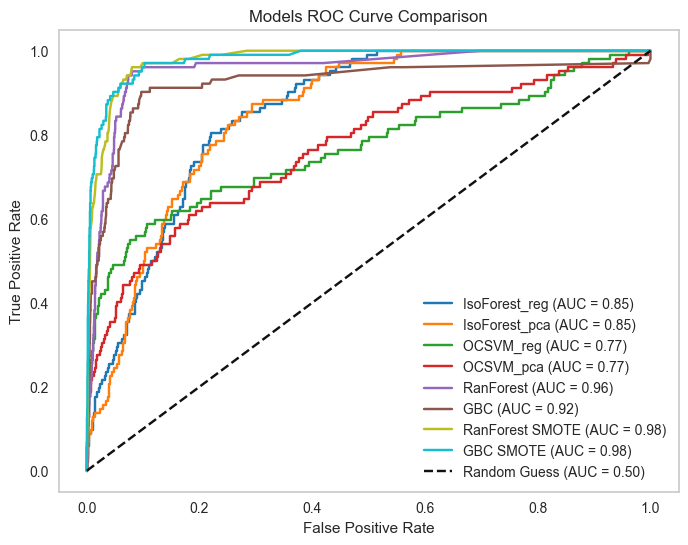

In [209]:
plt.figure(figsize=(8,6))
plt.plot(fpr_IF_reg, tpr_IF_reg, color='#1f77b4',
         label=f'IsoForest_reg (AUC = {roc_auc_IF_reg:.2f})')
plt.plot(fpr_IF_pca, tpr_IF_pca, color='#ff7f0e',
         label=f'IsoForest_pca (AUC = {roc_auc_IF_pca:.2f})')
plt.plot(fpr_ocsvm_reg, tpr_ocsvm_reg, color='#2ca02c',
         label=f'OCSVM_reg (AUC = {roc_auc_OCSVM_reg:.2f})')
plt.plot(fpr_ocsvm_pca, tpr_ocsvm_pca, color='#d62728',
         label=f'OCSVM_pca (AUC = {roc_auc_OCSVM_pca:.2f})')
plt.plot(fpr_RF, tpr_RF, color='#9467bd',
         label=f'RanForest (AUC = {roc_auc_RF:.2f})')
plt.plot(fpr_GBC, tpr_GBC, color='#8c564b',
         label=f'GBC (AUC = {roc_auc_GBC:.2f})')
plt.plot(fpr_RF_smote, tpr_RF_smote, color='#bcbd22',
         label=f'RanForest SMOTE (AUC = {roc_auc_RF_smote:.2f})')
plt.plot(fpr_GBC_smote, tpr_GBC_smote, color='#17becf',
         label=f'GBC SMOTE (AUC = {roc_auc_GBC_smote:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Models ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()